### Overview
**collaborative Filtering**
<br>从csdn上找到了豆瓣评分的数据库，包含约9万个用户对约2千部电影的40万条评分记录，希望构建一个基于用户的电影推荐系统。
<br>数据库下载地址：https://download.csdn.net/download/qq_37717661/10617933
* 针对不同用户推荐不同电影或者说预测用户对电影的评分：输入用户ID，电影ID，预测评分值
* 根据用户群的喜好(评分)对电影的进行分类或者说衡量电影间的相似度：输入电影ID，输出相似电影

### 算法-SVD
** $A=U{\sum}V^T$ **
<br>简单来说，奇异值分解的过程是把矩阵A的行空间通过V矩阵映射到奇异空间，把矩阵A的列空间通过U矩阵映射到奇异空间，或者说V是行空间里的一组正交基，U是列空间的一组正交基，U V把A的两个子空间映射到一个对角矩阵中，用奇异值表示。
<br>SVD是一个降维算法，他是对矩阵“最好”的low rank approximation，这里的最好的意思是矩阵的F范数变化最小(RMSE最小)。原因是SVD把矩阵拆解成了由一个个$\sigma·{\vec U_i}·{\vec V_i}$小矩阵的叠加组成，因为奇异向量UV都是单位向量，所以矩阵的范数就全由$\sigma$奇异值的大小决定，把对角矩阵的奇异值按从大到小排列，通过删掉奇异值较小的维度降维，是保证数据矩阵的范数变化最小。
<br>SVD对查找数据的潜在因素(latent factor)很有用，如电影音乐的品味喜好或发现潜在的主题。可以理解为给我们的数据定义了一个潜在概念空间(concept space)$V^T$把一行行的用户评分映射concept space，U把一列列电影得分映射到concept space，而每个concept或者说latent factor的强度由奇异值${\sum}$衡量。
<br>我们的数据很稀疏，每个用户只对少部分电影做出了评价，我们的目标就是预测填补这些空缺值。训练的目标就是用训练得到的矩阵跟原矩阵比F范数变化最小，这样我们成功的把一个推荐问题转换成了一个优化问题，输入潜在因素的维度，根据这个维度大小构建U，V空间，训练U，V的参数，使重构出的矩阵跟原数据矩阵相比 $\sqrt{\sum_i(A_i-B_i)^2}$ 趋近于0。
### Implementation using Surprise
Surprise库超好用
* Reader--定义评分数据的上下限
* Dataset--接收以user_id, product_id, rating这个固定顺序排列的数据集
* train_test_split(dataset, test_size=25%)--将数据集拆分成训练集和测试集
* SVD(n_factors=?)--训练模型，设置latent_factor潜在变量的维度
* **model.qi**--movie_to_LF matrix，movie到潜在变量空间的transform矩阵
<br>item_to_row_idx: Dict[Any, int] = **model.trainset._raw2inner_id_items** 得到qi矩阵的行序号对应着哪个个movie_id 可以每个电影对应的行空间向量之间的距离来衡量电影的相似度，或者做cluster

### 数据载入和清洗

In [1]:
import numpy as np
import pandas as pd
import sqlite3

首先从数据库中载入数据，看下数据库里有几张表，每个表有哪些属性，挑选有用的载入到dataframe里

In [2]:
conn = sqlite3.connect('../movie_filter/input/douban.db')
cur = conn.cursor()
cur.execute("select name from sqlite_master where type='table'")
tables = [i[0] for i in cur.fetchall()[1:]]
table_infos = {}
for (i,name) in enumerate(tables):
    cur.execute("PRAGMA table_info(%s)"%name)
    table_infos[name] = ' '.join([col[1] for col in cur.fetchall()])
data_info = pd.Series(table_infos)
data_info

comment          ID TIME MOVIEID RATING CONTENT CREATOR ADD_TIME
movie                                           ID NAME ADD_TIME
movie_chinese                                   ID NAME ADD_TIME
dtype: object

In [3]:
df_comment = pd.read_sql_query('SELECT ID,CREATOR,MOVIEID,RATING,ADD_TIME FROM comment ORDER BY ID',conn)
df_comment.rename(columns={"ID":'id',"CREATOR":'user',"MOVIEID":'movie_id',"RATING":'rating',"ADD_TIME":'time'},inplace=True)
df_comment.head()

,id,user,movie_id,rating,time
0,4264,身似,10440138,1,2018-01-05 15:05:06
1,4265,Ent,10440138,2,2018-01-05 15:05:06
2,4266,有意识的贱民,10440138,2,2018-01-05 15:05:06
3,4267,亿万露电,10440138,1,2018-01-05 15:05:06
4,4268,Marni,10440138,1,2018-01-05 15:05:06


In [4]:
df_movie = pd.read_sql_query('select ID as movie_id,NAME as movie,ADD_TIME as time from movie \
                             union select ID as movie_id,NAME as movie,ADD_TIME as time from movie_chinese',conn)
df_movie.head()

,movie_id,movie,time
0,10001432,颠倒的帕特玛,2018-02-07 20:46:08
1,10047547,饥饿游戏3：嘲笑鸟(下),2018-02-07 20:27:08
2,10174444,剧场版魔法少女小圆 前篇 起始的故事,2018-02-07 21:01:35
3,10342838,弯刀杀戮,2018-02-07 20:42:15
4,10344754,毒战,2018-02-07 20:23:20


In [5]:
conn.close()
import matplotlib.pyplot as plt

提取需要的数据--user_id, movie_id, rating；查看数据类型，把评分值转换成1～5的浮点数

In [6]:
print(df_comment.dtypes)

id           int64
user        object
movie_id    object
rating      object
time        object
dtype: object


In [7]:
df_ratings = df_comment[['movie_id','rating']].apply(pd.to_numeric,errors='coerce')
df_ratings['user'] = df_comment['user']
print(df_ratings.dtypes)

movie_id      int64
rating      float64
user         object
dtype: object


 先考察下整体评分数据的分布情况：

In [8]:
m_all = df_ratings['rating'].mean()
df_ratings['rating'].describe()

count    403946.000000
mean          3.237123
std           1.363416
min           1.000000
25%           2.000000
50%           4.000000
75%           4.000000
max           5.000000
Name: rating, dtype: float64

* 每部电影得到的用户评分数的分布情况，查看是否有异常值

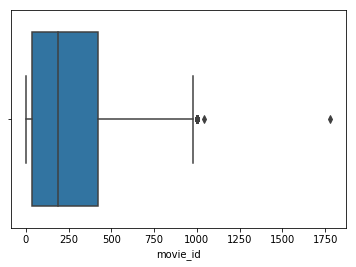

In [9]:
movie_ratings = df_ratings['movie_id'].value_counts()
import seaborn as sns
sns.boxplot(movie_ratings)

In [10]:
check_list = movie_ratings[movie_ratings>1000].index.tolist()
for movie_id in check_list:
    print(df_movie[df_movie['movie_id']==str(movie_id)]['movie'])

545    出租车司机
Name: movie, dtype: object
524    肖申克的救赎
Name: movie, dtype: object


* 查看下每用户评价的电影数的分布情况。

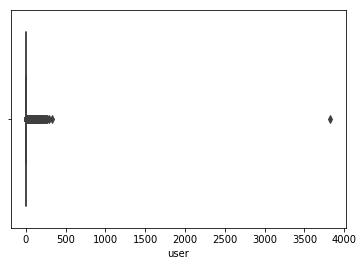

In [11]:
user_ratings = df_ratings['user'].value_counts()
sns.boxplot(user_ratings)

In [12]:
check_list = user_ratings[user_ratings>500].index.tolist()
for user in check_list:
    print(user)
print('评价电影数少于2的用户人数： ',len(user_ratings[user_ratings<2]))

[已注销]
评价电影数少于2的用户人数：  48630


这部分有大量异常值需要处理：有一部分评论来自已注销用户，被认为是同一个人，这部分数据应该去掉；还有有过半的用户只评价过一部电影，考虑到可能是水军，后面的分析是中通过用户对不同电影的打分反应用户的喜好来区分电影，只评价一部可能没有参考价值，这里先删掉。另外，数据集里没有提供用户的id号，需要添加一个。

In [13]:
count_by_user = df_ratings[['rating']].groupby(df_ratings['user']).count()
count_by_user['user_id'] = range(len(count_by_user))
count_by_user.rename(columns={"rating":'count'},inplace=True)
df_temp = df_ratings.join(count_by_user[['count','user_id']],on='user')
df_temp = df_temp[df_temp['user']!='[已注销]']
df_ratings_valid = df_temp[df_temp['count']>1][['user_id','movie_id','rating']].dropna()
print('invalid ratings: ', len(df_ratings_valid))
df_ratings_valid.head()

invalid ratings:  351568


,user_id,movie_id,rating
0,86120,10440138,1.0
1,5715,10440138,2.0
2,63218,10440138,2.0
3,38610,10440138,1.0
4,11104,10440138,1.0


In [32]:
print('电影数： ', len(df_ratings_valid['movie_id'].value_counts()))
print('用户数： ', len(df_ratings_valid['user_id'].value_counts()))
print('评论数： ', len(df_ratings_valid))

电影数：  1757
用户数：  45724
评论数：  351568


上面的就是清理过的要开始进行训练的数据集，大约35万条评论
### 训练
测试选择了100个潜在变量的维度，用Root Mean Squared Error来衡量准确度

In [41]:
from surprise import SVD,Dataset,Reader,accuracy
from surprise.model_selection import train_test_split,cross_validate

In [46]:
reader = Reader(rating_scale=(1,5))
data = Dataset.load_from_df(df_ratings_valid,reader)
trainset, testset = train_test_split(data, test_size=.25)
model = SVD(n_factors=100)
model.fit(trainset)
predictions = model.test(testset)
accuracy.rmse(predictions)

RMSE: 1.0357


1.0356966630081832

### 应用-预测评分
选一条评分，看下预测是否准确

In [50]:
df_ratings_valid[df_ratings_valid['user_id']==1][:1]

,user_id,movie_id,rating
51438,1,1292234,4.0


In [51]:
model.predict(1,1292234)

Prediction(uid=1, iid=1292234, r_ui=None, est=3.79349211445633, details={'was_impossible': False})

预测结果是3.79，实际值是4，还是比较准确的。。。
### 应用-相关推荐
输入电影名称，得到相似电影

In [76]:
from sklearn.metrics.pairwise import linear_kernel
model_cosine = linear_kernel(model.qi, model.qi)
__df_movie = df_movie[['movie_id']].apply(pd.to_numeric,errors='coerce')
__df_movie['movie'] = df_movie['movie']
__df_movie = __df_movie.set_index('movie_id')

In [77]:
def get_recommendation(movie,sim_mat=model_cosine):
    movie_id =int(df_movie[df_movie['movie']==movie]['movie_id'])
    id_dict = model.trainset._raw2inner_id_items
    idx = id_dict[movie_id]
    
    sim_scores = list(enumerate(sim_mat[idx]))
    sim_scores = sorted(sim_scores,key=lambda x:x[1],reverse=True)
    sim_scores = sim_scores[1:11]
    indices = [i[0] for i in sim_scores]
    
    id_dict_reverse ={value:key for key,value in id_dict.items()}
    movie_indices = [id_dict_reverse[i] for i in indices]
    
    df_recommended = __df_movie.loc[movie_indices]
    df_recommended.index = range(1,11)
    df_recommended =df_recommended.rename(columns={'movie':'相似电影'})
    return df_recommended

In [80]:
get_recommendation('饥饿游戏3：嘲笑鸟(下)')

,相似电影
1,死神来了5
2,天生爱情狂
3,服从
4,蝴蝶效应2
5,生命之树
6,弯刀杀戮
7,闪闪的红星
8,速度与激情8
9,生死狙击
10,忍者神龟：变种时代


这个结果好不好我也不知道怎么看啦。。。